Lam1 sequence: [1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04]
Lam2: 0
Estimated lam1: 0.01


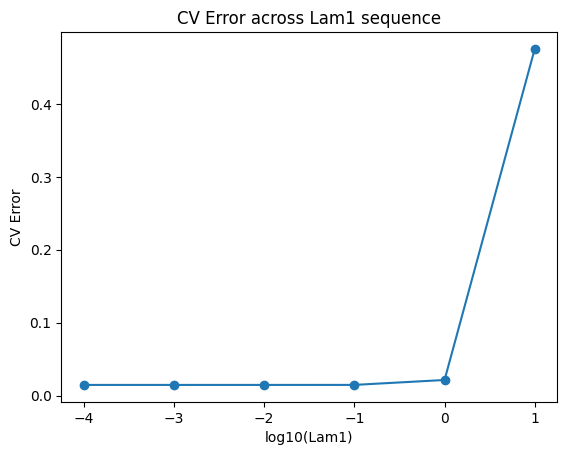

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import time


#Create simulation data
def create_simulated_data(n_samples=100, n_features=20, n_tasks=5, noise=0.1):
    X = np.random.randn(n_samples, n_features)
    true_coef = np.random.randn(n_features, n_tasks)
    Y = X @ true_coef + noise * np.random.randn(n_samples, n_tasks)
    return X, Y


X, Y = create_simulated_data()

# Define parameters
lam1_seq = 10 ** np.arange(1, -5, -1, dtype=float)
lam2 = 0
nfolds = 5

# Cross-validation
kf = KFold(n_splits=nfolds)
cv_errors = []

for lam1 in lam1_seq:
    fold_errors = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = Ridge(alpha=lam1)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        fold_errors.append(mean_squared_error(Y_test, Y_pred))

    cv_errors.append(np.mean(fold_errors))

cv_errors = np.array(cv_errors)

# The minimum cross-validation error corresponds to lam1

min_index = np.argmin(cv_errors)
best_lam1 = lam1_seq[min_index]

print("Lam1 sequence:", lam1_seq)
print("Lam2:", lam2)
print(f"Estimated lam1: {best_lam1}")

# Plot cross-validation error

plt.plot(np.log10(lam1_seq), cv_errors, marker='o')
plt.xlabel('log10(Lam1)')
plt.ylabel('CV Error')
plt.title('CV Error across Lam1 sequence')
plt.show()


CV without parallel computing time: 0.056357 secs
Lam1 sequence: [1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04]
Estimated lam1: 1.0


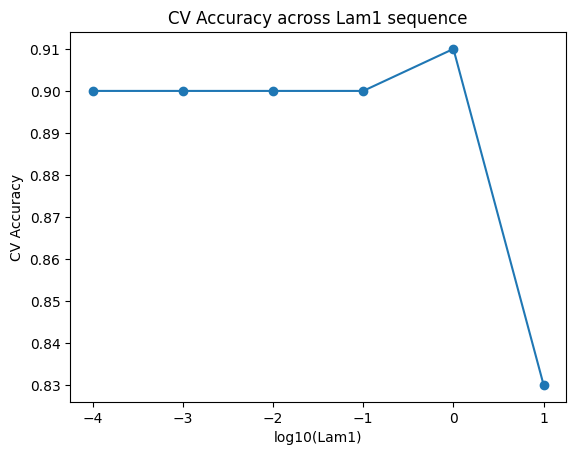

CV with parallel computing time: 0.684222 secs
Lam1 sequence (parallel): [1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04]
Estimated lam1 (parallel): 1.0


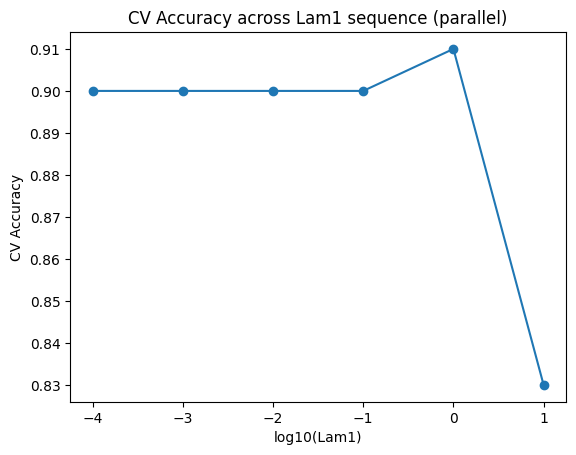

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from joblib import Parallel, delayed
import time
import matplotlib.pyplot as plt

# Function to create simulated data
def create_simulated_data(n_samples=100, n_features=20, n_tasks=5, noise=0.1, classification=False):
    X = np.random.randn(n_samples, n_features)
    if classification:
        # For classification, generate binary labels
        true_coef = np.random.randn(n_features)
        Y = np.dot(X, true_coef) + noise * np.random.randn(n_samples)
        Y = (Y > 0).astype(int)  # Convert to binary labels
    else:
        true_coef = np.random.randn(n_features, n_tasks)
        Y = X @ true_coef + noise * np.random.randn(n_samples, n_tasks)
    return X, Y

X, Y = create_simulated_data(n_samples=100, n_features=20, classification=True)

# Define parameters
lam1_seq = 10 ** np.arange(1, -5, -1, dtype=float)
nfolds = 5

# Stratified Cross-validation
skf = StratifiedKFold(n_splits=nfolds)
cv_errors = []

# Function to compute fold error
def compute_fold_error(train_index, test_index, lam1):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model = LogisticRegression(C=1/lam1, max_iter=10000)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return accuracy_score(Y_test, Y_pred)

# Cross-validation without parallel computing
start_time = time.time()
for lam1 in lam1_seq:
    fold_errors = []
    for train_index, test_index in skf.split(X, Y):
        fold_error = compute_fold_error(train_index, test_index, lam1)
        fold_errors.append(fold_error)
    cv_errors.append(np.mean(fold_errors))
cv_errors = np.array(cv_errors)
end_time = time.time()
print("CV without parallel computing time: {:.6f} secs".format(end_time - start_time))

# The maximum cross-validation accuracy corresponds to lam1
max_index = np.argmax(cv_errors)
best_lam1 = lam1_seq[max_index]

print("Lam1 sequence:", lam1_seq)
print(f"Estimated lam1: {best_lam1}")

# Plot cross-validation accuracy
plt.plot(np.log10(lam1_seq), cv_errors, marker='o')
plt.xlabel('log10(Lam1)')
plt.ylabel('CV Accuracy')
plt.title('CV Accuracy across Lam1 sequence')
plt.show()

# Cross-validation with parallel computing
start_time = time.time()
def parallel_cv(lam1):
    fold_errors = []
    skf = StratifiedKFold(n_splits=nfolds)
    for train_index, test_index in skf.split(X, Y):
        fold_error = compute_fold_error(train_index, test_index, lam1)
        fold_errors.append(fold_error)
    return np.mean(fold_errors)

cv_errors_parallel = Parallel(n_jobs=2)(delayed(parallel_cv)(lam1) for lam1 in lam1_seq)
cv_errors_parallel = np.array(cv_errors_parallel)
end_time = time.time()
print("CV with parallel computing time: {:.6f} secs".format(end_time - start_time))

# The maximum cross-validation accuracy corresponds to lam1 in parallel computing
max_index_parallel = np.argmax(cv_errors_parallel)
best_lam1_parallel = lam1_seq[max_index_parallel]

print("Lam1 sequence (parallel):", lam1_seq)
print(f"Estimated lam1 (parallel): {best_lam1_parallel}")

# Plot cross-validation accuracy with parallel computing
plt.plot(np.log10(lam1_seq), cv_errors_parallel, marker='o')
plt.xlabel('log10(Lam1)')
plt.ylabel('CV Accuracy')
plt.title('CV Accuracy across Lam1 sequence (parallel)')
plt.show()
